# Cálculo del valor de SpO2 a partir de los datos crudos del sensor

## Carga de datos y preprocesamiento 

Columnas en el CSV: Index(['Tiempo (ms)', 'IR', 'AMB_IR', 'RED', 'AMB_RED'], dtype='object')


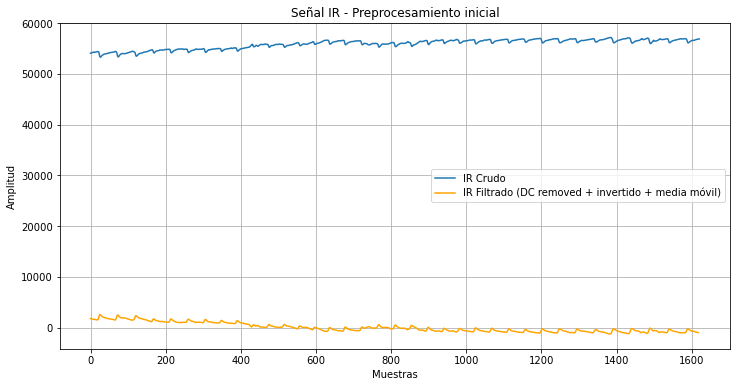

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo CSV
ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"  # Cambia el nombre por el que toque

# Cargar los datos
df = pd.read_csv(ruta_csv, delimiter = ";")
df = df[df['Tiempo (ms)'] >= 3000].reset_index(drop=True)

# Mostrar columnas disponibles
print("Columnas en el CSV:", df.columns)

# Suponiendo que las columnas se llaman 'IR' y 'RED'
ir_signal = df['IR'].values
red_signal = df['RED'].values

# 1. Calcular media (DC) y restar
ir_mean = np.mean(ir_signal)
ir_ac = ir_signal - ir_mean

# 2. Invertir la señal
ir_inverted = -1 * ir_ac

# 3. Aplicar media móvil de 4 puntos
def moving_average(signal, window_size=4):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

ir_filtered = moving_average(ir_inverted)

# Gráfica comparativa
plt.figure(figsize=(12, 6))
plt.plot(ir_signal, label='IR Crudo')
plt.plot(ir_filtered, label='IR Filtrado (DC removed + invertido + media móvil)', color='orange')
plt.legend()
plt.title('Señal IR - Preprocesamiento inicial')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


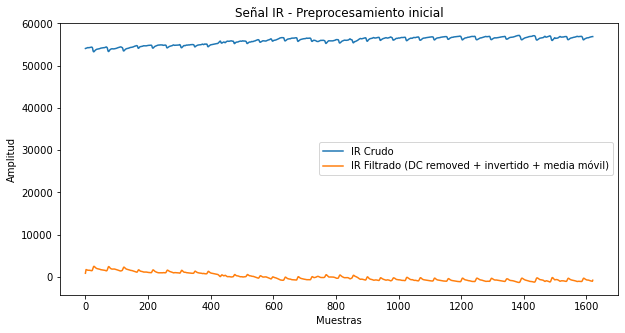

In [8]:
# Extraemos las señales
ir_raw = df['IR'].values
red_raw = df['RED'].values
tiempo = df['Tiempo (ms)'].values

# Preprocesado (como en el firmware C)
def preprocess_signal(signal):
    # Quitar componente DC
    signal_dc_removed = signal - np.mean(signal)
    # Invertir
    signal_inverted = -signal_dc_removed
    # Media móvil de 4 muestras
    kernel = np.ones(4)/4
    signal_filtered = np.convolve(signal_inverted, kernel, mode='same')
    return signal_filtered

ir_filtered = preprocess_signal(ir_raw)
red_filtered = preprocess_signal(red_raw)

# Visualización del preprocesado
plt.figure(figsize=(10,5))
plt.plot(ir_raw, label='IR Crudo')
plt.plot(ir_filtered, label='IR Filtrado (DC removed + invertido + media móvil)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Señal IR - Preprocesamiento inicial')
plt.legend()
plt.show()


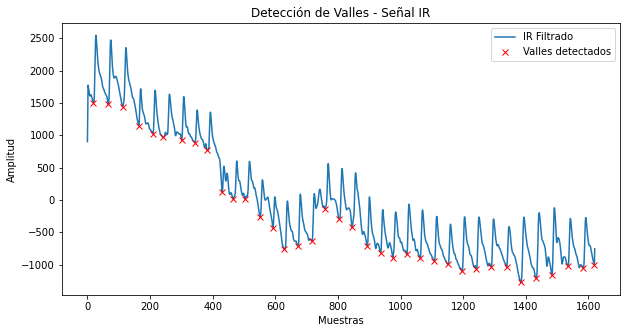

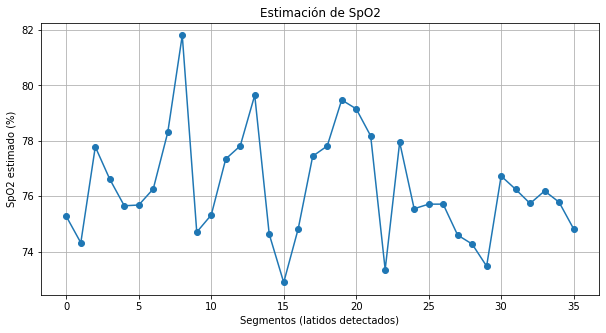

In [9]:
from scipy.signal import find_peaks

# Detectar valles (invirtiendo de nuevo la señal filtrada)
valles, _ = find_peaks(-ir_filtered, distance=30)  # Ajusta distance según tus datos

plt.figure(figsize=(10,5))
plt.plot(ir_filtered, label='IR Filtrado')
plt.plot(valles, ir_filtered[valles], 'rx', label='Valles detectados')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Detección de Valles - Señal IR')
plt.legend()
plt.show()

# Calcular R y estimar SpO2
ratios = []

for i in range(len(valles) - 1):
    ini = valles[i]
    fin = valles[i + 1]

    # Ventana actual
    ir_segment = ir_raw[ini:fin]
    red_segment = red_raw[ini:fin]

    # AC = max - min
    ac_ir = np.max(ir_segment) - np.min(ir_segment)
    ac_red = np.max(red_segment) - np.min(red_segment)

    # DC = media
    dc_ir = np.mean(ir_segment)
    dc_red = np.mean(red_segment)

    if dc_ir != 0 and dc_red != 0:
        R = (ac_red / dc_red) / (ac_ir / dc_ir)
        ratios.append(R)

# Convertir a array de numpy
ratios = np.array(ratios)

# Relación empírica para estimar SpO2 (simplificada)
# Se puede ajustar en base a documentación del sensor
spo2 = 110 - 25 * ratios  # Fórmula típica en MAX30102

# Visualización SpO2 estimado
plt.figure(figsize=(10,5))
plt.plot(spo2, marker='o')
plt.xlabel('Segmentos (latidos detectados)')
plt.ylabel('SpO2 estimado (%)')
plt.title('Estimación de SpO2')
plt.grid()
plt.show()


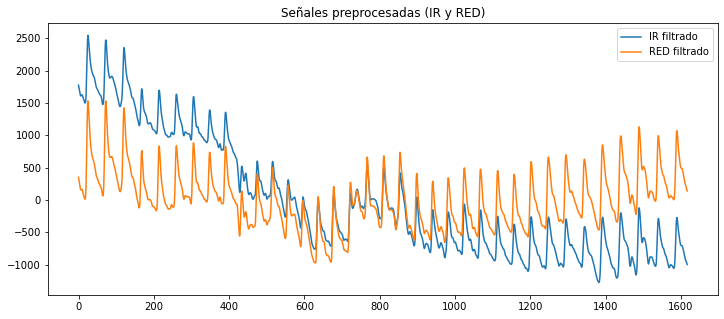

In [10]:
# Ruta al archivo CSV
ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"  # Cambia el nombre por el que toque

# Cargar los datos
df = pd.read_csv(ruta_csv, delimiter = ";")
df = df[df['Tiempo (ms)'] >= 3000].reset_index(drop=True)

# Señales originales
ir_signal = df['IR'].values
red_signal = df['RED'].values

# 1. Eliminar DC y centrar la señal
ir_mean = np.mean(ir_signal)
red_mean = np.mean(red_signal)

ir_signal_centered = ir_signal - ir_mean
red_signal_centered = red_signal - red_mean

# 2. Invertir señal para detectar valles como picos
ir_signal_inverted = -1 * ir_signal_centered
red_signal_inverted = -1 * red_signal_centered

# 3. Media móvil de 4 muestras (suavizado)
def moving_average(signal, window_size=4):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

ir_filtered = moving_average(ir_signal_inverted)
red_filtered = moving_average(red_signal_inverted)

# Visualizamos cómo quedan
plt.figure(figsize=(12, 5))
plt.plot(ir_filtered, label='IR filtrado')
plt.plot(red_filtered, label='RED filtrado')
plt.title('Señales preprocesadas (IR y RED)')
plt.legend()
plt.show()


Ahora voy a la detección de valles y el cálculo del ratio  R — que es lo que luego se usa para estimar la SpO2

- Detectar los valles (mínimos locales) de la señal IR.

    En cada valle mido:

    - La componente AC (pico a valle) de IR y RED.

    - La componente DC (valor medio alrededor del valle) de IR y RED.

- Calculo el ratio 

    R en cada valle:
 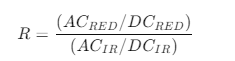
- Estimamo SpO2 con una fórmula empírica.

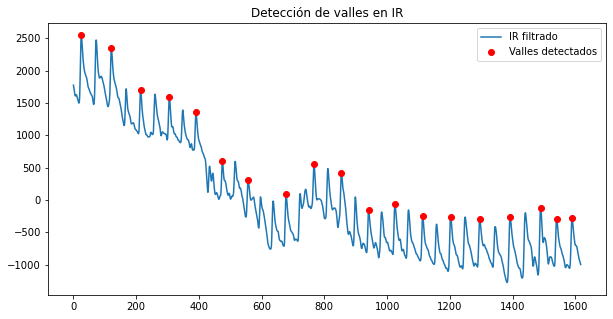

In [11]:
from scipy.signal import find_peaks

# Detectar valles (como picos en la señal invertida)
# min_distance en número de muestras -> ajustar según frecuencia de muestreo
min_distance = 50  # por ejemplo, si tienes 100 Hz y el pulso es 60-100 lpm

valles_ir, _ = find_peaks(ir_filtered, distance=min_distance)

plt.figure(figsize=(10,5))
plt.plot(ir_filtered, label='IR filtrado')
plt.plot(valles_ir, ir_filtered[valles_ir], 'ro', label='Valles detectados')
plt.legend()
plt.title('Detección de valles en IR')
plt.show()


In [12]:
ratios = []

# Recorremos cada valle detectado
for i in range(1, len(valles_ir)):
    start = valles_ir[i-1]
    end = valles_ir[i]
    
    # Señales en ese latido
    ir_segment = ir_filtered[start:end]
    red_segment = red_filtered[start:end]
    
    # AC = max - min
    ir_ac = np.max(ir_segment) - np.min(ir_segment)
    red_ac = np.max(red_segment) - np.min(red_segment)
    
    # DC = valor en el valle (aprox. el mínimo)
    ir_dc = ir_filtered[end]
    red_dc = red_filtered[end]
    
    if ir_ac > 0 and ir_dc > 0:
        ratio = (red_ac / red_dc) / (ir_ac / ir_dc)
        ratios.append(ratio)

# Promedio de ratios
R_promedio = np.mean(ratios)

# Estimación de SpO2 (fórmula empírica típica)
spo2_estimado = 110 - 25 * R_promedio

print(f'Ratio promedio R: {R_promedio:.3f}')
print(f'Valor estimado de SpO2: {spo2_estimado:.2f} %')


Ratio promedio R: 1.597
Valor estimado de SpO2: 70.09 %


In [13]:
import numpy as np
import scipy.signal as signal

def estimate_spo2(ir_signal, red_signal, fs, t_inicio=3):
    """
    Estima el valor de SpO2 a partir de las señales IR y RED.
    """

    # 1. Recortar primeros segundos
    muestras_inicio = int(t_inicio * fs)
    ir_signal = ir_signal[muestras_inicio:]
    red_signal = red_signal[muestras_inicio:]

    # 2. Calcular media (DC) y eliminar componente DC
    ir_mean = np.mean(ir_signal)
    red_mean = np.mean(red_signal)

    ir_ac = ir_signal - ir_mean
    red_ac = red_signal - red_mean

    # 3. Invertir señal IR y suavizar (ventana de 4 muestras)
    ir_ac = -ir_ac
    ir_ac = np.convolve(ir_ac, np.ones(4)/4, mode='same')

    # 4. Estimar umbral
    threshold = np.mean(ir_ac)
    threshold = np.clip(threshold, 30, 60)

    # 5. Detectar valles
    peaks, _ = signal.find_peaks(ir_ac, height=threshold, distance=4)

    # 6. Calcular ratios R
    R_values = []
    for i in range(len(peaks)-1):
        idx_start = peaks[i]
        idx_end = peaks[i+1]

        red_segment = red_signal[idx_start:idx_end]
        ir_segment = ir_signal[idx_start:idx_end]

        if len(red_segment) > 0 and len(ir_segment) > 0:
            red_ac_pp = np.ptp(red_segment)  # peak to peak
            ir_ac_pp = np.ptp(ir_segment)

            R = (red_ac_pp / red_mean) / (ir_ac_pp / ir_mean)
            R_values.append(R)

    # 7. Estimar SpO2
    if len(R_values) == 0:
        print("No se han detectado valles suficientes")
        return None, None

    R_avg = np.mean(R_values)

    spo2 = 110 - 25 * R_avg  # Fórmula estándar

    return spo2, R_avg


In [14]:
spo2_estimado, R_promedio = estimate_spo2(df['IR'].values, df['RED'].values, fs=60)

print(f"SpO2 estimado: {spo2_estimado:.2f} %")
print(f"Ratio R promedio: {R_promedio:.3f}")


SpO2 estimado: 77.08 %
Ratio R promedio: 1.317


Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_91_91.csv


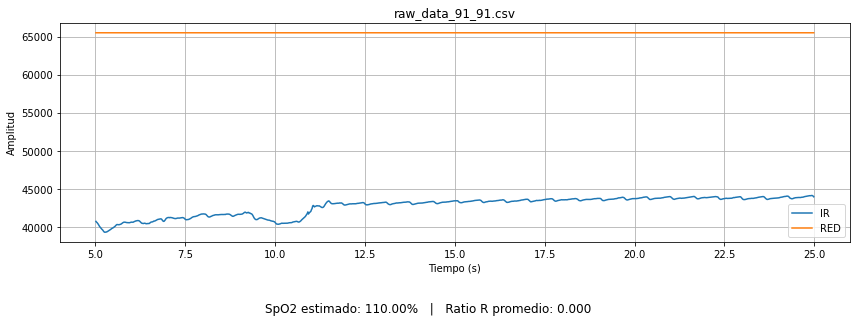

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_92_76.csv


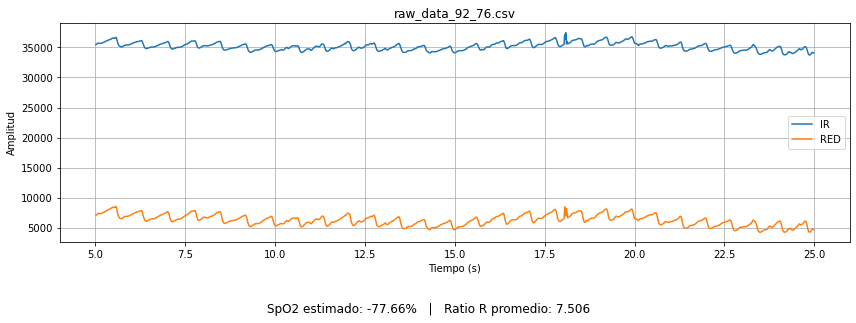

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_93_100.csv


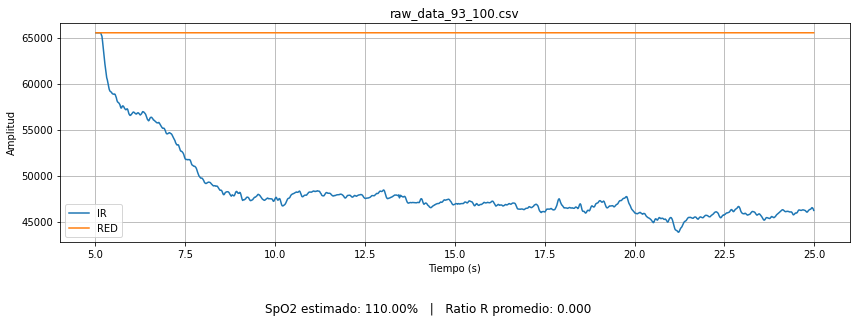

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_95_77_2.csv


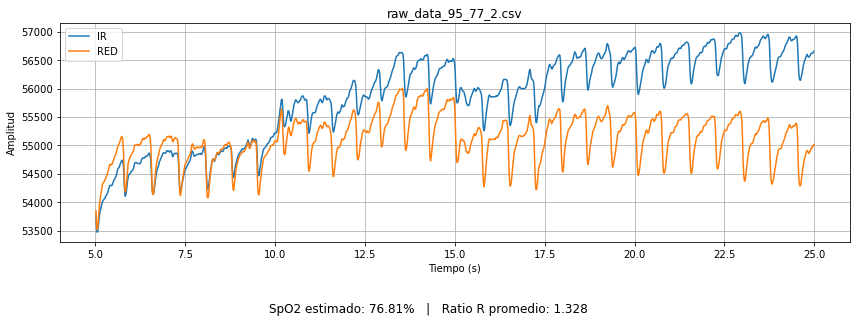

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_95_80.csv


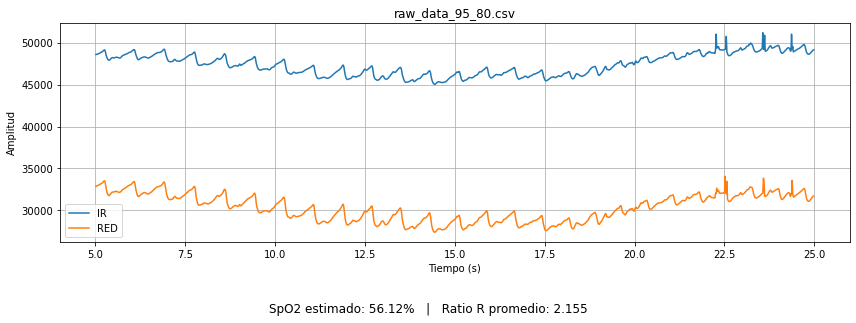

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_95_81_papa.csv


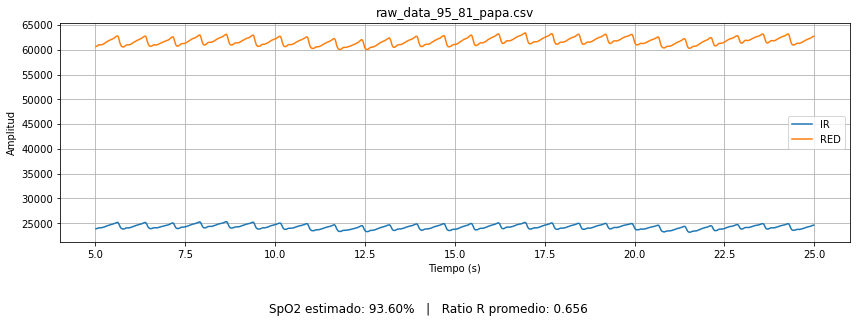

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_95_99.csv


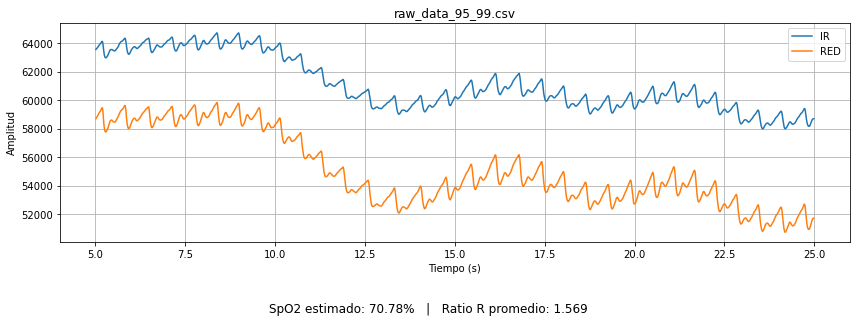

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_96_106.csv


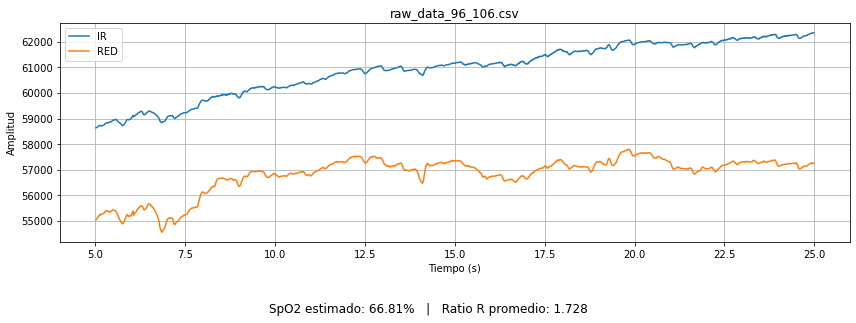

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_96_69.csv


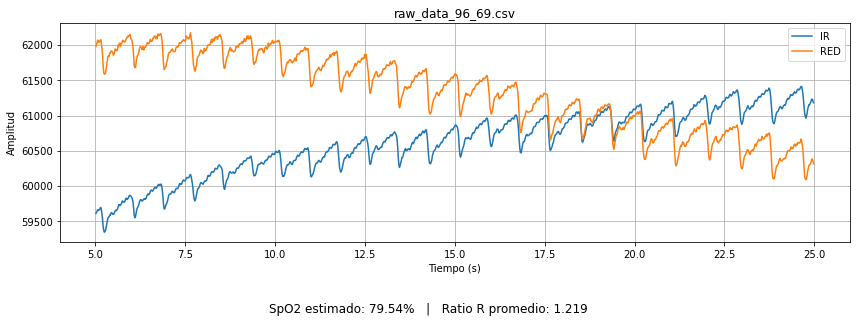

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_97_119.csv


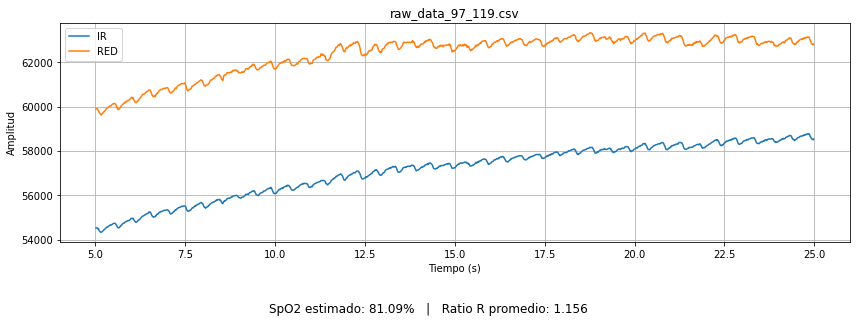

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_98_81.csv


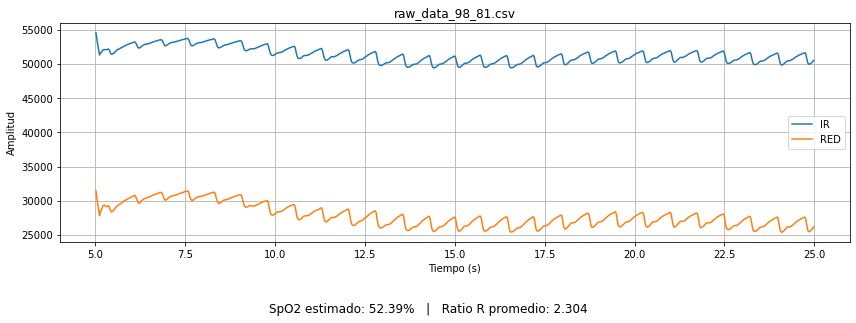

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_98_91.csv


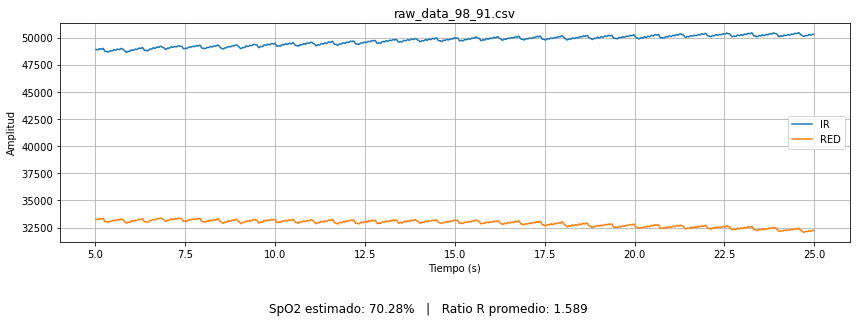

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_99_75.csv


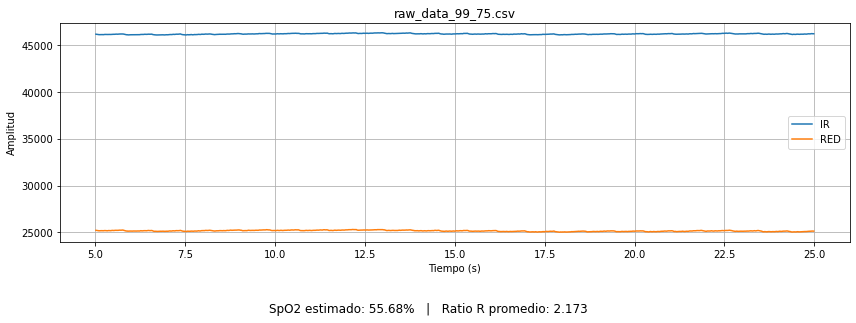

Procesando: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados\raw_data_99_91.csv


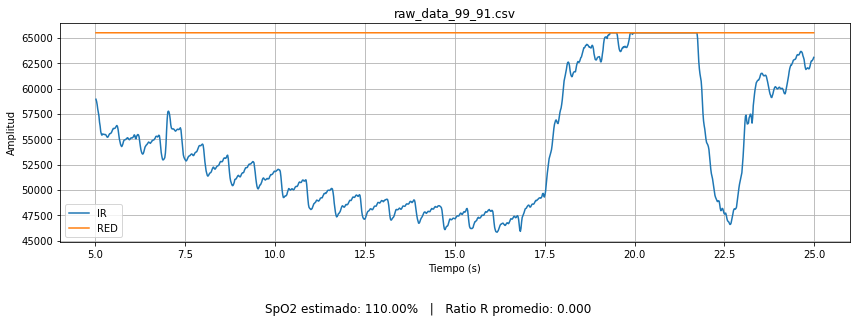

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Ruta de tus CSV
ruta = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Procesados'

# Obtener lista de todos los CSV
archivos_csv = glob.glob(os.path.join(ruta, '*.csv'))

# Para cada CSV
for archivo in archivos_csv:
    print(f'Procesando: {archivo}')

    df = pd.read_csv(archivo, delimiter = ";")

    # Llamar a tu función
    spo2, R = estimate_spo2(df['IR'].values, df['RED'].values, fs=60)

    # Graficar
    plt.figure(figsize=(12, 4))
    plt.plot(df['Tiempo (ms)']/1000, df['IR'], label='IR')
    plt.plot(df['Tiempo (ms)']/1000, df['RED'], label='RED')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'{os.path.basename(archivo)}')
    plt.legend()
    plt.grid()

    # Imprimir debajo de la gráfica
    plt.figtext(0.5, -0.1, f'SpO2 estimado: {spo2:.2f}%   |   Ratio R promedio: {R:.3f}',
                ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


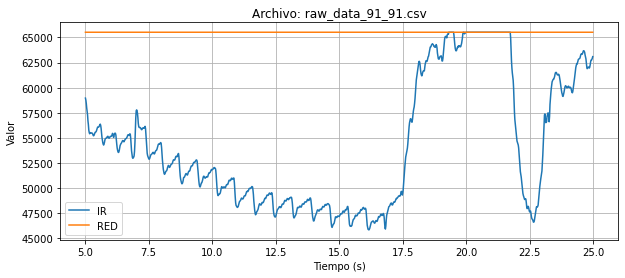

SpO2 estimado: 100.00%



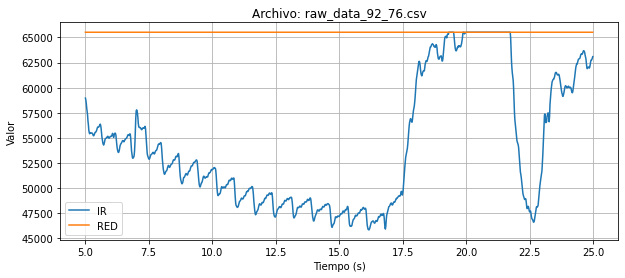

SpO2 estimado: 100.00%



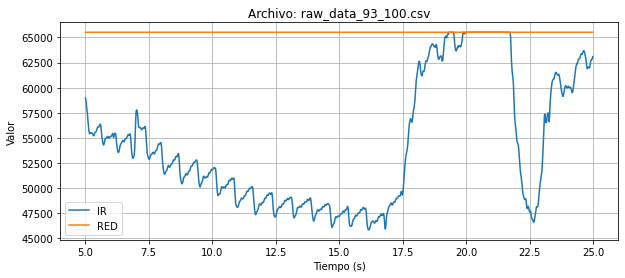

SpO2 estimado: 100.00%



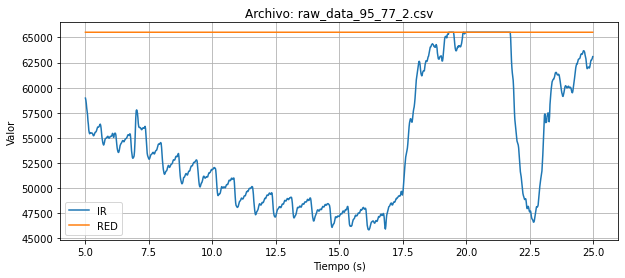

SpO2 estimado: 100.00%



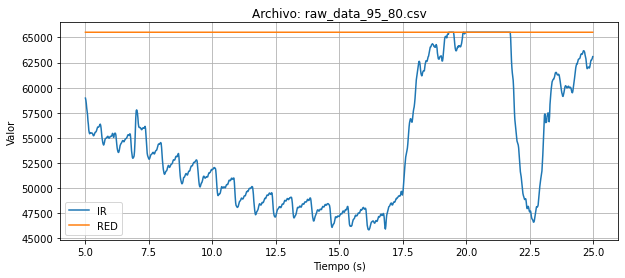

SpO2 estimado: 100.00%



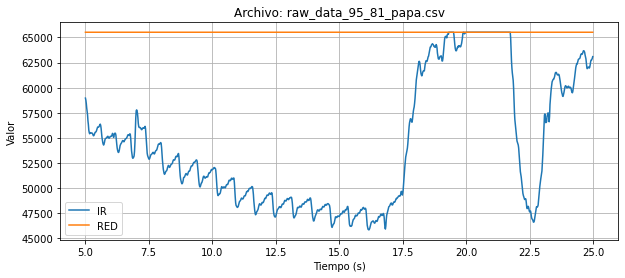

SpO2 estimado: 100.00%



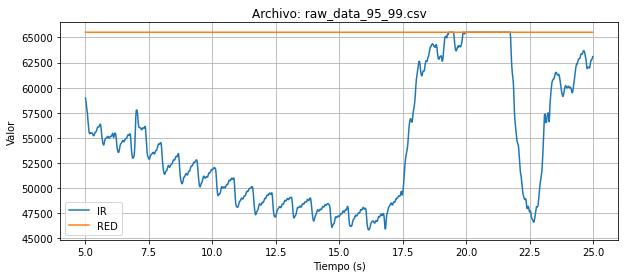

SpO2 estimado: 100.00%



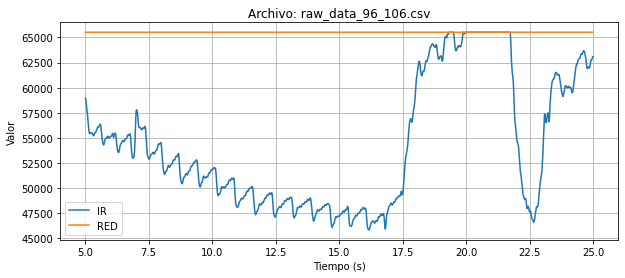

SpO2 estimado: 100.00%



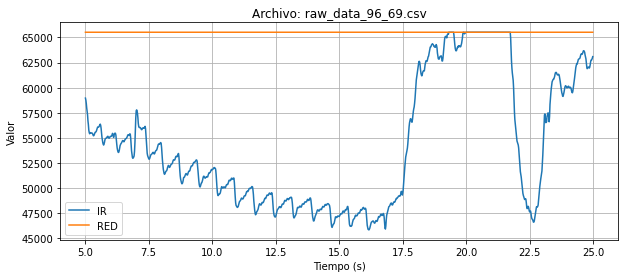

SpO2 estimado: 100.00%



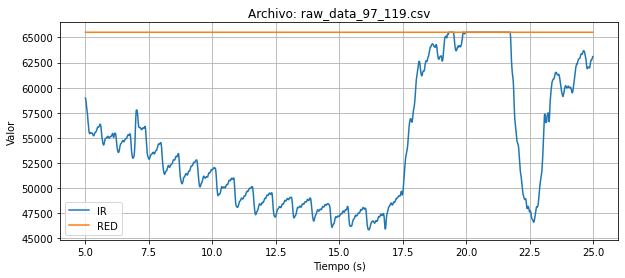

SpO2 estimado: 100.00%



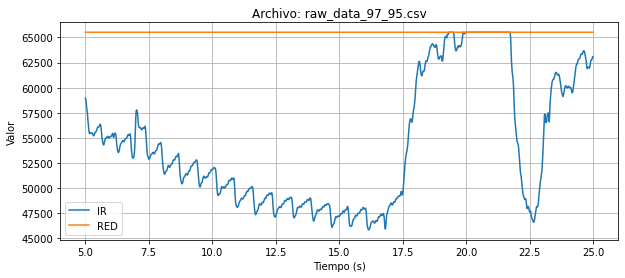

SpO2 estimado: 100.00%



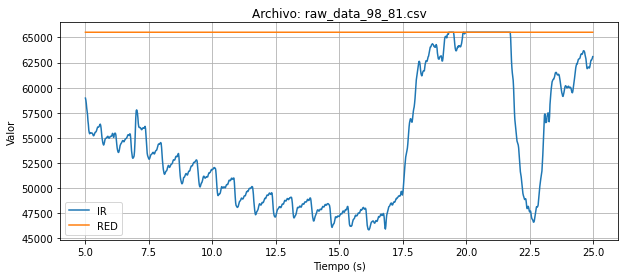

SpO2 estimado: 100.00%



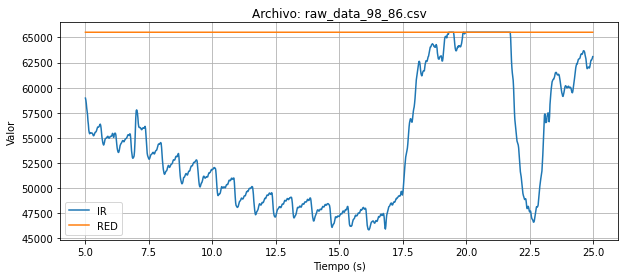

SpO2 estimado: 100.00%



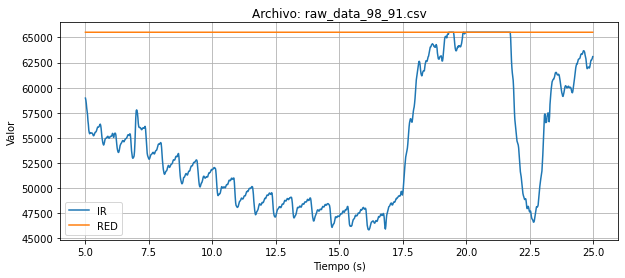

SpO2 estimado: 100.00%



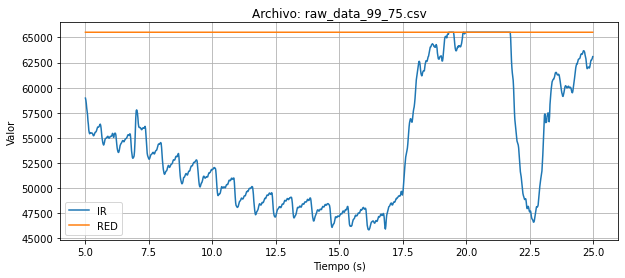

SpO2 estimado: 100.00%



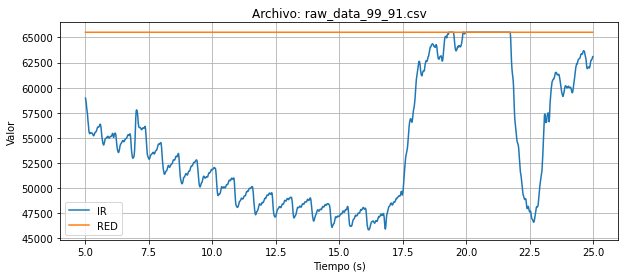

SpO2 estimado: 100.00%



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Ruta a tus CSV
path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"
csv_files = glob.glob(os.path.join(path, "*.csv"))

def preprocess_signal(df):
    df = pd.read_csv(archivo, delimiter = ";")
    tiempo_s = df['Tiempo (ms)'] / 1000  # ms -> s
    df = df[tiempo_s > 3].reset_index(drop=True)
    return df

# Cálculo de SpO2 (simplificado)
def estimate_spo2(ir_signal, red_signal):
    ir_ac = ir_signal - np.mean(ir_signal)
    red_ac = red_signal - np.mean(red_signal)

    rms_ir = np.sqrt(np.mean(ir_ac ** 2))
    rms_red = np.sqrt(np.mean(red_ac ** 2))

    ratio = (rms_red / np.mean(red_signal)) / (rms_ir / np.mean(ir_signal))
    spo2 = 110 - 25 * ratio  # Ajustar esta fórmula empíricamente
    spo2 = np.clip(spo2, 0, 100)

    return spo2

for file in csv_files:
    df = pd.read_csv(file)
    df = preprocess_signal(df)

    ir = df['IR']
    red = df['RED']

    spo2 = estimate_spo2(ir, red)

    plt.figure(figsize=(10, 4))
    plt.plot(df['Tiempo (ms)']/1000, ir, label='IR')
    plt.plot(df['Tiempo (ms)']/1000, red, label='RED')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Valor')
    plt.title(f'Archivo: {os.path.basename(file)}')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"SpO2 estimado: {spo2:.2f}%\n")
